# Generative AI | Homework 2 - Part 1 | Vyacheslav Stepanyan

# Task Overview

**Objective:** Predict data scientist salaries using Kaggle's Data Science Salary [dataset](https://www.kaggle.com/datasets/arnabchaki/data-science-salaries-2023/data) through a neural network model.

# Task Description

In this task, you will delve into the data science job market, with the goal of predicting a data scientist's salary. You will use a range of features that potentially influence salary, such as experience, education level, geographic location, and job specificity.

# Requirements

- **Data Preprocessing**:
  - **Outlier Removal**: Identify and remove outliers in the salary data, as these can skew the results and affect the performance of your neural network model. In order not to spend much time on it, do it only for target variable. Plot the target variable to see whether it has distribution close to normal afte outlier removal.

- **Encoding**:
  - **Target Encoding**: Apply target encoding to categorical features to transform them into meaningful numerical values. Remember that you need to fit it only on train data and then apply to train and test to eschew from data leakage.


- **Feature Scaling**:
 - Standardize your features using StandardScaler or MinMaxScaler to ensure that all features contribute equally to the model and to facilitate the model's convergence. Remember that you need to fit it only on train data and then apply to train and test to eschew from data leakage.

- **Neural Network Model**:
  - Construct a neural network with at least two hidden layers. Experiment with different numbers of neurons, activation functions, and layer configurations to find the best architecture for your model.

- **Loss Function**:

 - Use Mean Absolute Percentage Error (MAPE) as your loss function to penalize errors in prediction proportionally to the true salary values. This can be particularly useful when you want the model to give more importance to relative errors rather than absolute errors. You may need to define custom loss for this purpose.

- **Model Evaluation**:
  - Evaluate your model using MAPE as the primary metric.

- **Report**:
 - Document your findings, including the preprocessing steps, model architecture choices, evaluation results, and any insights you've gained from this exercise.

 **Hyperparameter Tuning** You are not required to do hyperparameter tuning but if you decide to do so (highly encouraged), do it with cross-validation.

 **Baseline** If you get MAPE of 35% or lower, you have good enough model. Moreover, you can use LightGBM for salary prediction and compare MAPE of two models.

In [1]:

import pandas as pd
import matplotlib.pyplot as plt
from category_encoders import TargetEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from tqdm import tqdm

C:\Users\User\AppData\Local\Temp\ipykernel_30784\3417683664.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cuda:0


In [3]:
df = pd.read_csv('ds_salaries.csv')
df.columns

Index(['work_year', 'experience_level', 'employment_type', 'job_title',
       'salary', 'salary_currency', 'salary_in_usd', 'employee_residence',
       'remote_ratio', 'company_location', 'company_size'],
      dtype='object')

In [4]:
# Read the dataset
df = pd.read_csv('ds_salaries.csv')

# Display the first few rows of the DataFrame
df = df[['salary_in_usd', 'work_year', 'experience_level', 'employment_type', 'job_title', 'employee_residence', 'remote_ratio', 'company_location', 'company_size']]
df.head()


,salary_in_usd,work_year,experience_level,employment_type,job_title,employee_residence,remote_ratio,company_location,company_size
0,85847,2023,SE,FT,Principal Data Scientist,ES,100,ES,L
1,30000,2023,MI,CT,ML Engineer,US,100,US,S
2,25500,2023,MI,CT,ML Engineer,US,100,US,S
3,175000,2023,SE,FT,Data Scientist,CA,100,CA,M
4,120000,2023,SE,FT,Data Scientist,CA,100,CA,M


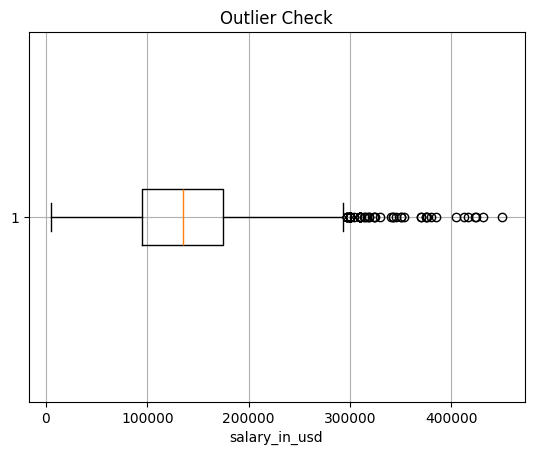

In [5]:
plt.boxplot(df['salary_in_usd'], vert=False)
plt.title(f'Outlier Check')
plt.xlabel('salary_in_usd')
plt.grid()
plt.show()

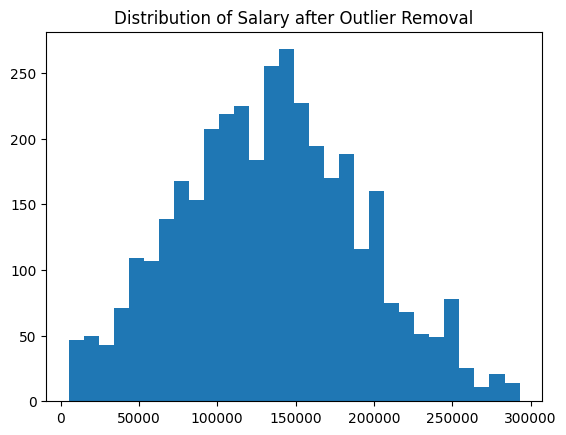

In [6]:
# Remove outliers
Q1 = df['salary_in_usd'].quantile(0.25)
Q3 = df['salary_in_usd'].quantile(0.75)
Q_range = Q3 - Q1

df = df[(df['salary_in_usd'] > Q1 - 1.5 * Q_range) & (df['salary_in_usd'] < Q3 + 1.5 * Q_range)]

plt.hist(df['salary_in_usd'], bins=30)
plt.title('Distribution of Salary after Outlier Removal')
plt.show()

In [7]:
# Split the data into training and testing sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [8]:
# Target Encoding
cat_features = ['experience_level', 'employment_type', 'job_title', 'employee_residence', 'company_location', 'company_size']
target_encoder = TargetEncoder()
train_df[cat_features] = target_encoder.fit_transform(train_df[cat_features], train_df['salary_in_usd'])
test_df[cat_features] = target_encoder.transform(test_df[cat_features])  # Apply encoding to test data

In [9]:
# Feature Scaling
scale_features = ['experience_level', 'work_year', 'employment_type', 'job_title', 'employee_residence', 'remote_ratio', 'company_location', 'company_size']
scaler = StandardScaler()
train_df[scale_features] = scaler.fit_transform(train_df[scale_features])
test_df[scale_features] = scaler.transform(test_df[scale_features])  # Apply scaling to test data

In [10]:
# Convert data to PyTorch tensors
X_train = torch.tensor(train_df.drop('salary_in_usd', axis=1).values, dtype=torch.float32)
X_train = X_train.to(device)
y_train = torch.tensor(train_df['salary_in_usd'].values, dtype=torch.float32)
y_train = y_train.to(device)

X_test = torch.tensor(test_df.drop('salary_in_usd', axis=1).values, dtype=torch.float32)
X_test = X_test.to(device)
y_test = torch.tensor(test_df['salary_in_usd'].values, dtype=torch.float32)
y_test = y_test.to(device)

In [14]:
# Convert data to PyTorch tensors
X_train = torch.tensor(train_df.drop('salary_in_usd', axis=1).values, dtype=torch.float32)
X_train = X_train.to('cpu')
y_train = torch.tensor(train_df['salary_in_usd'].values, dtype=torch.float32)
y_train = y_train.to('cpu')

X_test = torch.tensor(test_df.drop('salary_in_usd', axis=1).values, dtype=torch.float32)
X_test = X_test.to('cpu')
y_test = torch.tensor(test_df['salary_in_usd'].values, dtype=torch.float32)
y_test = y_test.to('cpu')

In [15]:
# Define the neural network architecture
class SalaryPredictionModel(nn.Module):
    def __init__(self, input_size):
        super(SalaryPredictionModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(64, 32)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(32, 32)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(32, 1)
        self.relu4 = nn.ReLU()

    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.relu3(self.fc3(x))
        x = self.relu4(self.fc4(x))
        return x

In [16]:
# Initialize the model
input_size = X_train.shape[1]
model = SalaryPredictionModel(input_size)
#model = model.cuda()

In [17]:
# MAPE Loss 
class MAPELoss(nn.Module):
    def __init__(self):
        super(MAPELoss, self).__init__()

    def forward(self, y_pred, y_true):
        eps = 1e-8
        mape = torch.mean(torch.abs((y_true - y_pred)/(y_true+ eps))) *100
        
        return mape

In [18]:
# Define loss function and optimizer
lr = 0.0001
criterion = MAPELoss()  # Using Mean Absolute Error (MAE) as loss function
optimizer = optim.Adam(model.parameters(), lr=lr)
#criterion = criterion.cuda()


c:\Users\User\Desktop\AUA\Generative AI\GenAI_venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [19]:
batch_size = 1
train_loader = DataLoader(list(zip(X_train, y_train)), shuffle=False,batch_size= batch_size)
test_loader = DataLoader(list(zip(X_test, y_test)), shuffle=False, batch_size= batch_size)

In [20]:
# Training loop for salary prediction
num_epochs = 200
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for X_batch, y_batch in tqdm(train_loader):
        optimizer.zero_grad()

        # Forward pass
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    average_loss = total_loss / len(train_loader)

    print(f"Epoch {epoch + 1}/{num_epochs} - Average Loss: {average_loss}")


100%|██████████| 2953/2953 [00:02<00:00, 1383.53it/s]


Epoch 1/200 - Average Loss: 99.95201880496678


100%|██████████| 2953/2953 [00:02<00:00, 1297.10it/s]


Epoch 2/200 - Average Loss: 99.16593255812622


100%|██████████| 2953/2953 [00:02<00:00, 1167.73it/s]


Epoch 3/200 - Average Loss: 96.40574721211382


100%|██████████| 2953/2953 [00:02<00:00, 1224.85it/s]


Epoch 4/200 - Average Loss: 92.17379089198752


100%|██████████| 2953/2953 [00:02<00:00, 1252.06it/s]


Epoch 5/200 - Average Loss: 87.07461371334617


100%|██████████| 2953/2953 [00:02<00:00, 1178.60it/s]


Epoch 6/200 - Average Loss: 80.80890545257058


100%|██████████| 2953/2953 [00:02<00:00, 1168.89it/s]


Epoch 7/200 - Average Loss: 71.86889776852911


100%|██████████| 2953/2953 [00:02<00:00, 1239.50it/s]


Epoch 8/200 - Average Loss: 59.92855094414857


100%|██████████| 2953/2953 [00:02<00:00, 1238.05it/s]


Epoch 9/200 - Average Loss: 48.615815888697966


100%|██████████| 2953/2953 [00:02<00:00, 1137.78it/s]


Epoch 10/200 - Average Loss: 41.2664123538628


100%|██████████| 2953/2953 [00:02<00:00, 1218.03it/s]


Epoch 11/200 - Average Loss: 37.54150883508696


100%|██████████| 2953/2953 [00:02<00:00, 1209.09it/s]


Epoch 12/200 - Average Loss: 35.56293419784617


100%|██████████| 2953/2953 [00:02<00:00, 1238.88it/s]


Epoch 13/200 - Average Loss: 34.29471013652614


100%|██████████| 2953/2953 [00:02<00:00, 1327.69it/s]


Epoch 14/200 - Average Loss: 33.42217609763733


100%|██████████| 2953/2953 [00:02<00:00, 1326.28it/s]


Epoch 15/200 - Average Loss: 32.76581766830661


100%|██████████| 2953/2953 [00:02<00:00, 1344.31it/s]


Epoch 16/200 - Average Loss: 32.28047462382038


100%|██████████| 2953/2953 [00:02<00:00, 1325.29it/s]


Epoch 17/200 - Average Loss: 31.922111218094006


100%|██████████| 2953/2953 [00:02<00:00, 1346.34it/s]


Epoch 18/200 - Average Loss: 31.62820500814565


100%|██████████| 2953/2953 [00:02<00:00, 1339.26it/s]


Epoch 19/200 - Average Loss: 31.393298991759966


100%|██████████| 2953/2953 [00:02<00:00, 1291.21it/s]


Epoch 20/200 - Average Loss: 31.199605513295324


100%|██████████| 2953/2953 [00:02<00:00, 1270.60it/s]


Epoch 21/200 - Average Loss: 31.02975773789579


100%|██████████| 2953/2953 [00:02<00:00, 1243.07it/s]


Epoch 22/200 - Average Loss: 30.92377575866555


100%|██████████| 2953/2953 [00:02<00:00, 1274.30it/s]


Epoch 23/200 - Average Loss: 30.82949961954649


100%|██████████| 2953/2953 [00:02<00:00, 1338.29it/s]


Epoch 24/200 - Average Loss: 30.745866608653824


100%|██████████| 2953/2953 [00:02<00:00, 1321.51it/s]


Epoch 25/200 - Average Loss: 30.6651481233242


100%|██████████| 2953/2953 [00:02<00:00, 1251.25it/s]


Epoch 26/200 - Average Loss: 30.590580462238332


100%|██████████| 2953/2953 [00:02<00:00, 1309.20it/s]


Epoch 27/200 - Average Loss: 30.51776786401989


100%|██████████| 2953/2953 [00:02<00:00, 1317.72it/s]


Epoch 28/200 - Average Loss: 30.450048590586714


100%|██████████| 2953/2953 [00:02<00:00, 1306.12it/s]


Epoch 29/200 - Average Loss: 30.385465595390254


100%|██████████| 2953/2953 [00:02<00:00, 1297.78it/s]


Epoch 30/200 - Average Loss: 30.32250620642684


100%|██████████| 2953/2953 [00:02<00:00, 1287.49it/s]


Epoch 31/200 - Average Loss: 30.265644275981025


100%|██████████| 2953/2953 [00:02<00:00, 1207.54it/s]


Epoch 32/200 - Average Loss: 30.210398472969814


100%|██████████| 2953/2953 [00:02<00:00, 1215.39it/s]


Epoch 33/200 - Average Loss: 30.158062415156493


100%|██████████| 2953/2953 [00:02<00:00, 1323.53it/s]


Epoch 34/200 - Average Loss: 30.109428423527493


100%|██████████| 2953/2953 [00:02<00:00, 1293.86it/s]


Epoch 35/200 - Average Loss: 30.066788563002095


100%|██████████| 2953/2953 [00:02<00:00, 1286.81it/s]


Epoch 36/200 - Average Loss: 30.02823516338844


100%|██████████| 2953/2953 [00:02<00:00, 1297.10it/s]


Epoch 37/200 - Average Loss: 29.989858310667767


100%|██████████| 2953/2953 [00:02<00:00, 1155.43it/s]


Epoch 38/200 - Average Loss: 29.951753600120842


100%|██████████| 2953/2953 [00:02<00:00, 1200.73it/s]


Epoch 39/200 - Average Loss: 29.92012146997903


100%|██████████| 2953/2953 [00:02<00:00, 1224.80it/s]


Epoch 40/200 - Average Loss: 29.887723500969987


100%|██████████| 2953/2953 [00:02<00:00, 1217.71it/s]


Epoch 41/200 - Average Loss: 29.858818563962714


100%|██████████| 2953/2953 [00:02<00:00, 1249.55it/s]


Epoch 42/200 - Average Loss: 29.83076272829899


100%|██████████| 2953/2953 [00:02<00:00, 1196.94it/s]


Epoch 43/200 - Average Loss: 29.802045861259735


100%|██████████| 2953/2953 [00:02<00:00, 1216.97it/s]


Epoch 44/200 - Average Loss: 29.775032855894747


100%|██████████| 2953/2953 [00:02<00:00, 1214.54it/s]


Epoch 45/200 - Average Loss: 29.74685066161047


100%|██████████| 2953/2953 [00:02<00:00, 1236.54it/s]


Epoch 46/200 - Average Loss: 29.720062675574574


100%|██████████| 2953/2953 [00:02<00:00, 1222.51it/s]


Epoch 47/200 - Average Loss: 29.694068514647974


100%|██████████| 2953/2953 [00:02<00:00, 1240.31it/s]


Epoch 48/200 - Average Loss: 29.665986212032895


100%|██████████| 2953/2953 [00:02<00:00, 1217.92it/s]


Epoch 49/200 - Average Loss: 29.64491237948191


100%|██████████| 2953/2953 [00:02<00:00, 1158.31it/s]


Epoch 50/200 - Average Loss: 29.622483408271567


100%|██████████| 2953/2953 [00:02<00:00, 1250.46it/s]


Epoch 51/200 - Average Loss: 29.601127096738324


 92%|█████████▏| 2725/2953 [00:02<00:00, 1311.64it/s]

In [ ]:
# Evaluation on validation set
model.eval()
with torch.no_grad():
    test_loss = 0
    for test_batch in tqdm(test_loader):
        test_inputs, test_targets = test_batch
        test_outputs = model(test_inputs)
        test_loss += criterion(test_outputs, test_targets).item()
    
    average_test_loss = test_loss/len(test_loader)

    print(f'MAPE Test Loss: {average_test_loss}%')

100%|██████████| 93/93 [00:00<00:00, 4895.21it/s]

MAPE Test Loss: 99.99840127268145%
